#Importing Dependencies & Dataset:

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for tensorflow-gpu ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> tensorflow-gpu

note: This i

In [ ]:
# Limiting the GPU utilization so that we prevent out of memory errors
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
# We will only take the training data from the dataset
ds = tfds.load('lfw', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/lfw/0.1.0.incompleteZYB64O/lfw-train.tfrecord*...:   0%|          | 0/1323…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

#Visualizing & Building The Dataset:

In [ ]:
import numpy as np

### We want to iterate over the data without putting it all in memory. Therefore, we will create a data iterator. 

In [ ]:
data_iterator = ds.as_numpy_iterator()

In [ ]:
# We iteratre over the data in samples using "next()"
data_iterator.next()

{'image': array([[[207, 209, 195],
         [207, 209, 195],
         [208, 210, 196],
         ...,
         [215, 218, 201],
         [215, 218, 201],
         [215, 218, 201]],
 
        [[207, 209, 195],
         [207, 209, 195],
         [208, 210, 196],
         ...,
         [215, 218, 201],
         [215, 218, 201],
         [215, 218, 201]],
 
        [[207, 209, 195],
         [207, 209, 195],
         [208, 210, 196],
         ...,
         [215, 218, 201],
         [215, 218, 201],
         [215, 218, 201]],
 
        ...,
 
        [[ 30,  29,  25],
         [ 29,  28,  24],
         [ 29,  28,  24],
         ...,
         [ 24,  22,  23],
         [ 23,  21,  22],
         [ 23,  21,  22]],
 
        [[ 30,  29,  25],
         [ 29,  28,  24],
         [ 29,  28,  24],
         ...,
         [ 27,  25,  26],
         [ 25,  23,  24],
         [ 24,  22,  23]],
 
        [[ 30,  29,  25],
         [ 29,  28,  24],
         [ 29,  28,  24],
         ...,
         [ 27,  25,

In [ ]:
print(data_iterator.next()['image'].shape)

(250, 250, 3)


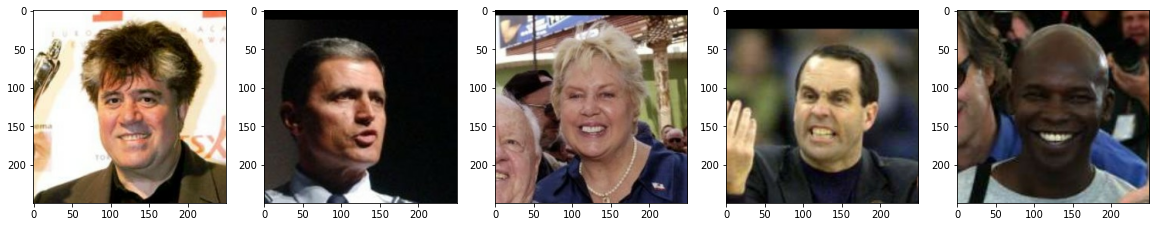

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for i in range(5): 
    sample = data_iterator.next()
    img = sample['image']
    ax[i].imshow(img)

###Our images' values are between 0 & 255. We want to scale them to 0 & 1. We are also resizing the image to 28X28 to save on memory.

In [ ]:
def scale_images(data): 
    image = data['image']
    image = tf.image.resize(image, [28,28]) 
    image = tf.cast(image,"uint8")
    return image / 255

### We are going to pass our dataset through a pipeline:
- <b>map</b>: Apply a function to all the images.
- <b>cache</b>: The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.
- <b>shuffle</b>: This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
- <b>batch</b>
- <b>prefetch</b>: Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [ ]:
# Reload the dataset 
ds = tfds.load('lfw', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(13233)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 3)

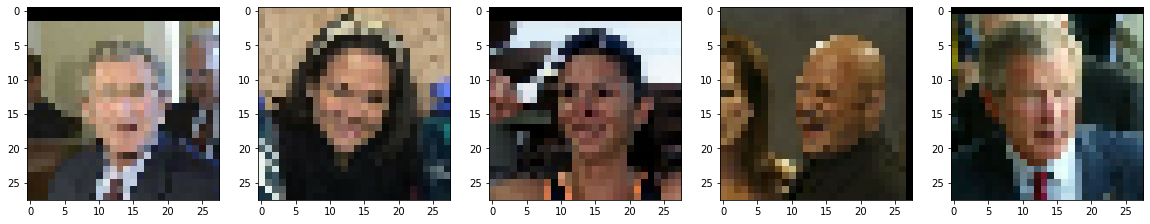

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for i in range(5): 
    images = ds.as_numpy_iterator().next()
    ax[i].imshow(images[i])

#Building The Generator:

In [ ]:
# These will be used for both the generator and the discriminator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

###We want the output image to be 28 X 28 X 3 like our dataset
###We can calculate the output of the Conv2D function as follows:
[(W−K+2P)/S]+1.

- W is the input volume - in your case 128
- K is the Kernel size - in your case 5
- P is the padding - in your case 0 i believe
- S is the stride - which you have not provided.

In [ ]:
def build_generator(): 
    model = Sequential()
    
    # We are going to generate based on 128 random values
    # Takes in random values and reshapes it to 7x7x128. We are giving the 128 random values (array) some spatial area to output an image
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D()) # This gets us to 14X11X128
    model.add(Conv2D(filters = 128, kernel_size = 5, strides = 1, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 5, strides = 1, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    
    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
# Generator expects the 128 numbers to be enclosed in an array
img = generator.predict(np.random.randn(1,128,1))

1/1 [==============================] - 7s 7s/step


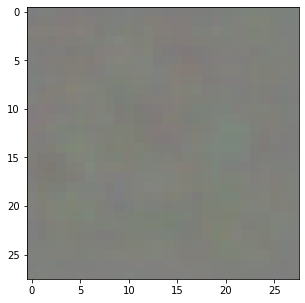

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(np.squeeze(img))   

From the image above. We can see that our generator can't generate any images of faces. Which is to be expected since it hasn't been trained.

#Building The Discriminator:

In [ ]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) # 1 will represent a fake image and 0 will represent a real one
    
    return model 

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img.shape

(1, 28, 28, 3)

In [ ]:
# Discriminator expects the image to be enclosed in an array (We can predict multiple images at once)
discriminator.predict(img)

1/1 [==============================] - 0s 141ms/step


array([[0.5463984]], dtype=float32)

#Training The Models:

We can't just use the fit function when training a GAN. We also need to adjust the speed at which the discriminator trains so that it doesn't easily recognize all the fake images of the generator.

Optimizer & Loss:

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
# We will make the learning rate of the generator higher than the discriminator to make it learn faster
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

##Building Sub-Class Model:

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class CelebGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs): #*args are any positional arguments. **kwargs are any keyword arguments.
        # Pass through args and kwargs to base class from the keras model
        super().__init__(*args, **kwargs)
        
        # Create attributes for generator and discriminator
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch): # This is called when we call the fit function. "test_step(self)" is called when we call an evaluation function
        
        # Get the data 
        # The batch is 128 images of 28X28X3
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False) # Since we are not training the generator in this call
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: # By default GradientTape will automatically watch any trainable variables that are accessed inside this context
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)  # Training = True is used to activate the dropout layers
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs to prevent the discriminator from learning too fast
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) # "self.discriminator.trainable_variables" this allows us to calculate the gradient for each one of our training variables.
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False) # We don't want the discriminator to be learning while we are training the generator
                                        
            # Calculate loss. If discirminator says that all images are real (equal to 0), then loss will be 0
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
celebgan = CelebGAN(generator, discriminator)

In [ ]:
celebgan.compile(g_opt, d_opt, g_loss, d_loss)

##Building The Callback:

This will allow us to save example images as we are training

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
os.mkdir("images")

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128): # number of images that we want to generate and how big our latent dimension (random values) is
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None): # "on_epoch_end" means that the images will be generated when an epoch finishes
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

##Training:

We want to see both losses steady. We don't want one of them to deviate a lot from the other.

In [ ]:
# It is recommended to train for at least 2500 epochs
hist = celebgan.fit(ds, epochs=30, callbacks=[ModelMonitor()])

Epoch 1/30
  6/104 [>.............................] - ETA: 16s - d_loss: 0.6931 - g_loss: 0.6935

104/104 [==============================] - 17s 164ms/step - d_loss: 0.6933 - g_loss: 0.6937
Epoch 2/30
104/104 [==============================] - 17s 165ms/step - d_loss: 0.6933 - g_loss: 0.6933
Epoch 3/30
104/104 [==============================] - 17s 159ms/step - d_loss: 0.6933 - g_loss: 0.6943
Epoch 4/30
104/104 [==============================] - 16s 157ms/step - d_loss: 0.6932 - g_loss: 0.6945
Epoch 5/30
104/104 [==============================] - 17s 162ms/step - d_loss: 0.6933 - g_loss: 0.6958
Epoch 6/30
104/104 [==============================] - 17s 162ms/step - d_loss: 0.6933 - g_loss: 0.6968
Epoch 7/30
104/104 [==============================] - 17s 161ms/step - d_loss: 0.6933 - g_loss: 0.6946
Epoch 8/30
104/104 [==============================] - 17s 159ms/step - d_loss: 0.6934 - g_loss: 0.6947
Epoch 9/30
104/104 [==============================] - 17s 160ms/step - d_loss: 0.6934 - g_loss: 0.6942
Epoch 10/30
104/104 [==============================] - 17s 159ms/step - d_loss: 0.69

##Performance Checking:

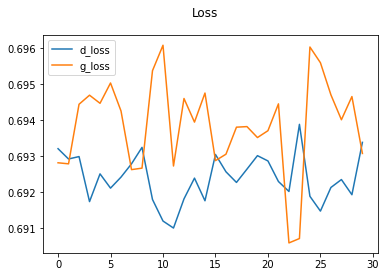

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

#Testing:

In [ ]:
imgs = generator.predict(tf.random.normal((1, 128, 1)))

1/1 [==============================] - 0s 76ms/step


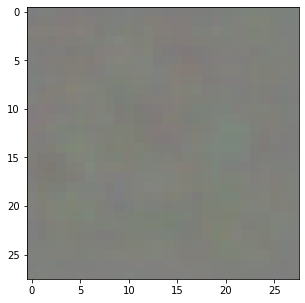

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(np.squeeze(img))   

#Saving The Model:

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')